In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(0)

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,GRU, Dropout,BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras import regularizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

In [7]:
import mlxtend

In [8]:
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR

In [9]:
svr_rbf = SVR(kernel='rbf')

In [10]:
# %pip install scikeras

In [11]:
from scikeras.wrappers import KerasRegressor

In [12]:
def create_ANN_model():

    ANN_model = Sequential()
    ANN_model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
    ANN_model.add(Dropout(0.5))  
    ANN_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    ANN_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    ANN_model.add(Dense(1, activation='linear'))  


    ANN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    return ANN_model



In [13]:
def create_GRU_model():
    GRU_model = Sequential()
    GRU_model.add(GRU(units=64, activation='relu', input_shape=(X_train.shape[1],1)))
    GRU_model.add(Dense(units=1))  

    optimizer = Adam(learning_rate=0.001)  
    GRU_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
    return GRU_model

In [14]:
def create_CNN_model():

    CNN_model = Sequential()
    CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    CNN_model.add(MaxPooling1D(pool_size=2))
    CNN_model.add(Flatten())
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(1)) 

    optimizer = Adam(learning_rate=0.001)
    CNN_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    

    return CNN_model

In [15]:

ann_regressor = KerasRegressor(build_fn=create_ANN_model, epochs=10, batch_size=32, verbose=0)
gru_regressor = KerasRegressor(build_fn=create_GRU_model, epochs=10, batch_size=32, verbose=0)
cnn_regressor = KerasRegressor(build_fn=create_CNN_model, epochs=10, batch_size=32, verbose=0)


In [16]:

# ann_regressor = KerasRegressor(build_fn=lambda: ANN_model, epochs=10, batch_size=32, verbose=0)
# gru_regressor = KerasRegressor(build_fn=lambda: GRU_model, epochs=10, batch_size=32, verbose=0)
# cnn_regressor = KerasRegressor(build_fn=lambda: CNN_model, epochs=10, batch_size=32, verbose=0)

In [17]:
regressors = [ann_regressor, gru_regressor, cnn_regressor]


In [18]:
stregr = StackingRegressor(
    regressors=regressors,
    meta_regressor = svr_rbf
)

In [19]:
crime= pd.read_csv("State+UT Wise Crime Data of India (IPC) 2001-2019 .csv")

In [20]:
crime = crime[["Year","Category","State_UT","Crime_Rate"]]
# crime = crime.rename({"Crime Rate": "Crime_Rate"}, axis=1)
# crime = crime.rename({"State/UT": "State_UT"}, axis=1)
crime

,Year,Category,State_UT,Crime_Rate
0,2001,Union Territory,A & N Islands,184.831461
1,2001,State,Andhra Pradesh,171.784545
2,2001,State,Arunachal Pradesh,214.665445
3,2001,State,Assam,138.437570
4,2001,State,Bihar,106.700129
...,...,...,...,...
660,2019,State,Tamil Nadu,221.759662
661,2019,State,Tripura,133.400000
662,2019,State,Uttar Pradesh,156.273399
663,2019,State,Uttarakhand,108.059034


In [21]:

X1 = crime[['Year', 'Category', 'State_UT']]
y1 = crime['Crime_Rate']


transformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [1, 2])], remainder='passthrough')
X_encoded1 = transformer.fit_transform(X1)


scaler = StandardScaler(with_mean=False)  # Do not center sparse matrices
X_scaled1 = scaler.fit_transform(X_encoded1)


X_reshaped1 = X_scaled1.toarray().reshape((X_scaled1.shape[0], X_scaled1.shape[1]))


X_train1, X_test1, y_train1, y_test1 = train_test_split(X_reshaped1, y1, test_size=0.2, random_state=42)


In [22]:
X_train1.shape

(532, 38)

In [23]:
y_train1.ndim

1

In [24]:
if X_train1.ndim == 3:
    num_samples, num_features, _ = X_train1.shape
    X_train1 = X_train1.reshape(num_samples, num_features)


print("Reshaped X_train shape:", X_train1.shape)

Reshaped X_train shape: (532, 38)


In [25]:
import numpy as np


print("X_train shape:", X_train1.shape)
print("y_train shape:", y_train1.shape)


# if np.isnan(X_train1).any() or np.isnan(y_train1).any():
#     print("Warning: There are NaN values in the input data. Handle them appropriately.")
# elif X_train1.ndim != 2:
#     print("Warning: X_train should have 2 dimensions (samples, features). Reshape if necessary.")
# elif y_train1.ndim != 1:
#     print("Warning: y_train should have 1 dimension (target values). Reshape if necessary.")
# else:
stregr.fit(X_train1, y_train1)


X_train shape: (532, 38)
y_train shape: (532,)


StackingRegressor(meta_regressor=SVR(),
                  regressors=[KerasRegressor(batch_size=32, build_fn=<function create_ANN_model at 0x0000018567800310>, epochs=10, verbose=0),
                              KerasRegressor(batch_size=32, build_fn=<function create_GRU_model at 0x00000185768E6160>, epochs=10, verbose=0),
                              KerasRegressor(batch_size=32, build_fn=<function create_CNN_model at 0x000001856BD54A60>, epochs=10, verbose=0)])

In [26]:
pred_stack = stregr.predict(X_test1)
pred_stack

array([201.20959389, 192.68432848, 206.19392532, 224.36694506,
       204.74502686, 206.7048317 , 207.59234199, 207.53831709,
       127.06534899, 186.48403858, 212.04304987, 207.26222537,
       202.31545316, 161.35081399, 161.63504341, 163.37020966,
       216.99074314, 126.03388745, 201.17751738, 142.43672148,
       171.69318162, 202.87471394, 203.59062669, 153.33043944,
       126.09882901, 218.77906784, 126.77581992, 161.92026344,
       222.62916409, 190.85313407, 147.6634463 , 133.17664842,
       224.04957858, 165.36192417, 126.44364338, 126.34986066,
       200.01494488, 129.23311322, 203.82385733, 126.12244396,
       191.35176627, 125.66148045, 126.16932314, 200.38095684,
       127.05569518, 160.46097153, 143.7755827 , 187.4926743 ,
       186.16546823, 224.32075673, 144.44616658, 183.26208009,
       140.44186483, 195.35900513, 160.3062879 , 176.40962682,
       142.17715182, 189.88777559, 223.51004175, 129.69236385,
       131.47214843, 142.22132816, 199.42490507, 125.96

In [27]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test1, pred_stack)
mse = mean_squared_error(y_test1, pred_stack)
rmse = np.sqrt(mse)
r2 = r2_score(y_test1, pred_stack)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 57.797140909307295
Mean Squared Error (MSE): 141.72610444784934
R-squared (R^2): 0.15019578945683976


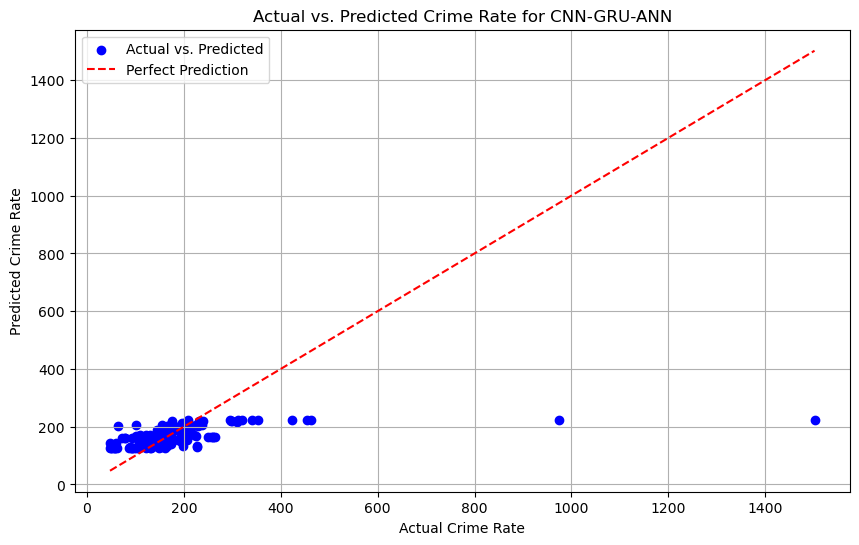

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test1, pred_stack, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('Actual vs. Predicted Crime Rate for CNN-GRU-ANN')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
grouped_data = pd.read_csv("01_District_wise_crimes_committed_IPC .csv")

grouped_data


,STATE/UT,DISTRICT,YEAR,MURDER,ATTEMPT TO MURDER,CULPABLE HOMICIDE NOT AMOUNTING TO MURDER,RAPE,CUSTODIAL RAPE,OTHER RAPE,KIDNAPPING & ABDUCTION,...,ARSON,HURT/GREVIOUS HURT,DOWRY DEATHS,ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY,INSULT TO MODESTY OF WOMEN,CRUELTY BY HUSBAND OR HIS RELATIVES,IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES,CAUSING DEATH BY NEGLIGENCE,OTHER IPC CRIMES,TOTAL IPC CRIMES
0,ANDHRA PRADESH,ANDHRA PRADESH,2001,101,60,17,50,0,50,46,...,30,1131,16,149,34,175,0,181,1518,4154
1,ANDHRA PRADESH,ANDHRA PRADESH,2001,151,125,1,23,0,23,53,...,69,1543,7,118,24,154,0,270,754,4125
2,ANDHRA PRADESH,ANDHRA PRADESH,2001,101,57,2,27,0,27,59,...,38,2088,14,112,83,186,0,404,1262,5818
3,ANDHRA PRADESH,CUDDAPAH,2001,80,53,1,20,0,20,25,...,23,795,17,126,38,57,0,233,1181,3140
4,ANDHRA PRADESH,EAST GODAVARI,2001,82,67,1,23,0,23,49,...,41,1244,12,109,58,247,0,431,2313,6507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9380,Delhi UT,STF,2013,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,15
9381,Delhi UT,WEST,2013,55,54,6,184,0,184,711,...,15,235,22,400,94,529,0,234,2393,8813
9382,Lakshadweep,LAKSHADWEEP,2013,0,0,0,2,0,2,0,...,1,5,0,1,0,0,0,0,18,40
9383,Puducherry,KARAIKAL,2013,6,3,0,6,0,6,3,...,3,160,1,1,1,1,0,32,329,643


In [30]:
grouped_data.columns

Index(['STATE/UT', 'DISTRICT', 'YEAR', 'MURDER', 'ATTEMPT TO MURDER',
       'CULPABLE HOMICIDE NOT AMOUNTING TO MURDER', 'RAPE', 'CUSTODIAL RAPE',
       'OTHER RAPE', 'KIDNAPPING & ABDUCTION',
       'KIDNAPPING AND ABDUCTION OF WOMEN AND GIRLS',
       'KIDNAPPING AND ABDUCTION OF OTHERS', 'DACOITY',
       'PREPARATION AND ASSEMBLY FOR DACOITY', 'ROBBERY', 'BURGLARY', 'THEFT',
       'AUTO THEFT', 'OTHER THEFT', 'RIOTS', 'CRIMINAL BREACH OF TRUST',
       'CHEATING', 'COUNTERFIETING', 'ARSON', 'HURT/GREVIOUS HURT',
       'DOWRY DEATHS', 'ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY',
       'INSULT TO MODESTY OF WOMEN', 'CRUELTY BY HUSBAND OR HIS RELATIVES',
       'IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES',
       'CAUSING DEATH BY NEGLIGENCE', 'OTHER IPC CRIMES', 'TOTAL IPC CRIMES'],
      dtype='object')

In [31]:
import pandas as pd

# Read the data into a DataFrame
data = pd.read_csv("01_District_wise_crimes_committed_IPC .csv")


grouped_data = data.groupby("STATE/UT").sum().reset_index()

grouped_data = grouped_data.drop(columns=["YEAR","DISTRICT", "TOTAL IPC CRIMES"])

state_mapping = {
    "A & N ISLANDS": "A & N Islands",
    "A&N Islands": "A & N Islands",
    "ANDHRA PRADESH": "Andhra Pradesh",
    "ARUNACHAL PRADESH": "Arunachal Pradesh",
    "ASSAM": "Assam",
    "Andhra Pradesh": "Andhra Pradesh",
    "Arunachal Pradesh": "Arunachal Pradesh",
    "Assam": "Assam",
    "BIHAR": "Bihar",
    "Bihar": "Bihar",
    "CHANDIGARH": "Chandigarh",
    "CHHATTISGARH": "Chhattisgarh",
    "Chandigarh": "Chandigarh",
    "Chhattisgarh": "Chhattisgarh",
    "D & N HAVELI": "D & N Haveli",
    "D&N Haveli": "D & N Haveli",
    "DAMAN & DIU": "Daman & Diu",
    "DELHI UT": "Delhi",
    "Daman & Diu": "Daman & Diu",
    "Delhi UT": "Delhi",
    "GOA": "Goa",
    "GUJARAT": "Gujarat",
    "Goa": "Goa",
    "Gujarat": "Gujarat",
    "HARYANA": "Haryana",
    "HIMACHAL PRADESH": "Himachal Pradesh",
    "Haryana": "Haryana",
    "Himachal Pradesh": "Himachal Pradesh",
    "JAMMU & KASHMIR": "Jammu & Kashmir",
    "JHARKHAND": "Jharkhand",
    "Jammu & Kashmir": "Jammu & Kashmir",
    "Jharkhand": "Jharkhand",
    "KARNATAKA": "Karnataka",
    "KERALA": "Kerala",
    "Karnataka": "Karnataka",
    "Kerala": "Kerala",
    "LAKSHADWEEP": "Lakshadweep",
    "Lakshadweep": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Maharashtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghalaya",
    "MIZORAM": "Mizoram",
    "Madhya Pradesh": "Madhya Pradesh",
    "Maharashtra": "Maharashtra",
    "Manipur": "Manipur",
    "Meghalaya": "Meghalaya",
    "Mizoram": "Mizoram",
    "NAGALAND": "Nagaland",
    "Nagaland": "Nagaland",
    "ODISHA": "Odisha",
    "Odisha": "Odisha",
    "PUDUCHERRY": "Puducherry",
    "PUNJAB": "Punjab",
    "Puducherry": "Puducherry",
    "Punjab": "Punjab",
    "RAJASTHAN": "Rajasthan",
    "Rajasthan": "Rajasthan",
    "SIKKIM": "Sikkim",
    "Sikkim": "Sikkim",
    "TAMIL NADU": "Tamil Nadu",
    "TRIPURA": "Tripura",
    "Tamil Nadu": "Tamil Nadu",
    "Tripura": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarakhand",
    "Uttar Pradesh": "Uttar Pradesh",
    "Uttarakhand": "Uttarakhand",
    "WEST BENGAL": "West Bengal",
    "West Bengal": "West Bengal"
}


grouped_data["STATE/UT"] = grouped_data["STATE/UT"].map(state_mapping)
grouped_data = grouped_data.groupby("STATE/UT").sum().reset_index()


grouped_data.to_csv("aggregated_data_crimes_for_state.csv", index=False)

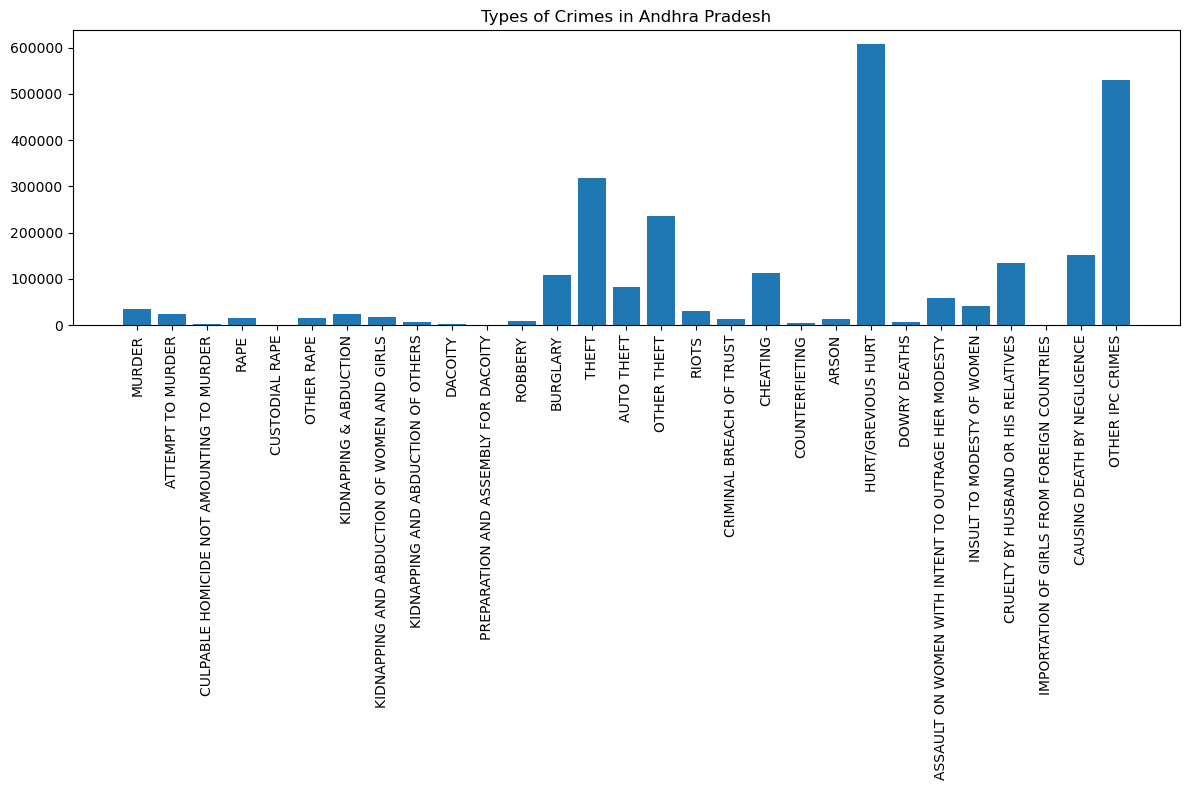

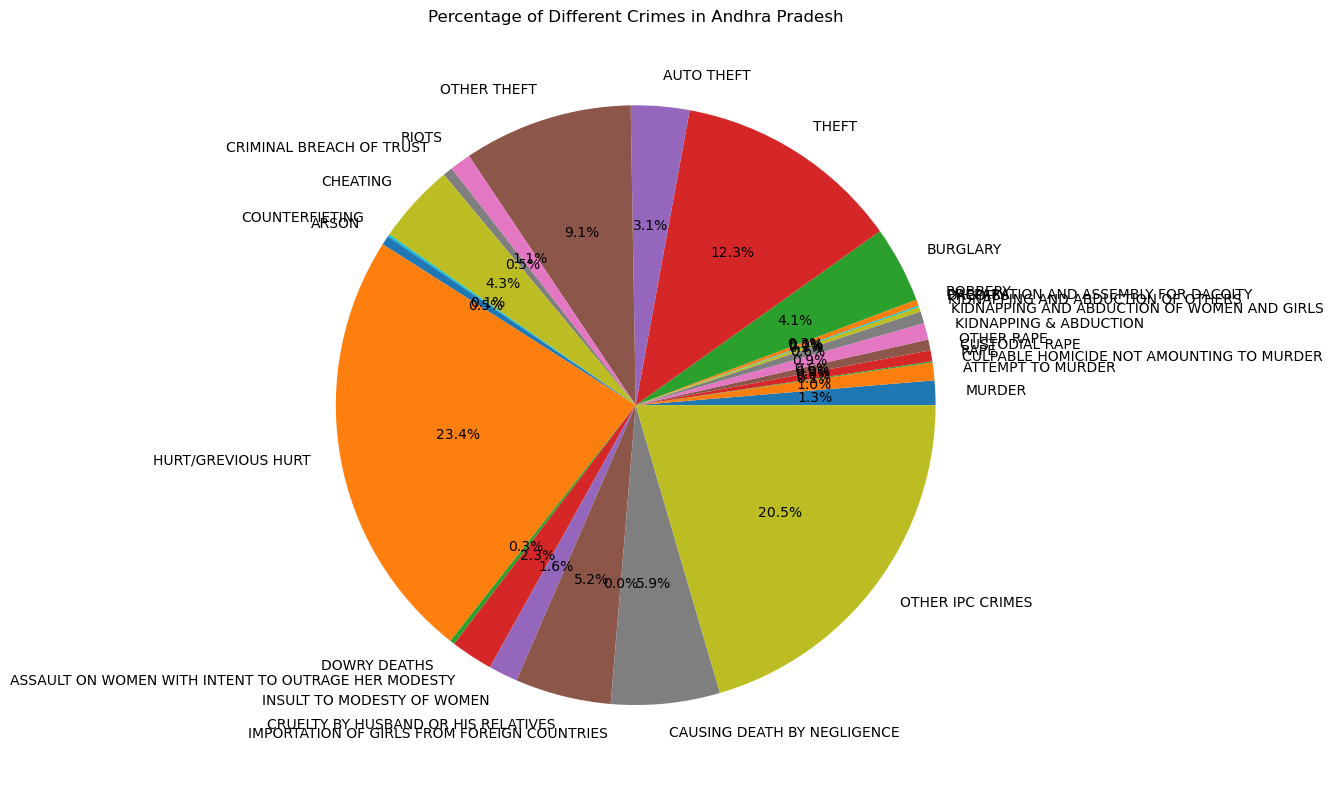

In [32]:

grouped_data = pd.read_csv("aggregated_data_crimes_for_state.csv")

def plot_crimes_for_state(state,plot_type):
    state_data = grouped_data[grouped_data['STATE/UT'] == state]

    state_data = state_data.dropna()

    state_data_values = state_data.iloc[0, 1:].astype(int)

    plt.figure(figsize=(12, 8))

    if plot_type == 'bar':
        plt.bar(state_data_values.index, state_data_values)
        plt.title('Types of Crimes in {}'.format(state))
    
    elif plot_type == 'pie':
        plt.pie(state_data_values, labels=state_data_values.index, autopct='%1.1f%%')
        plt.title('Percentage of Different Crimes in {}'.format(state))
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



plot_crimes_for_state('Andhra Pradesh', plot_type='bar')

plot_crimes_for_state('Andhra Pradesh', plot_type='pie')


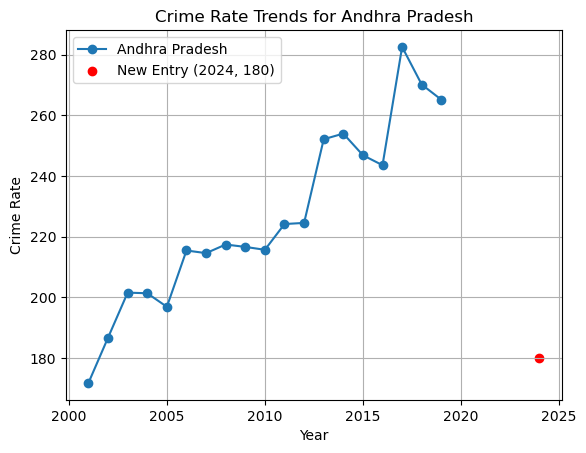

In [33]:




def plot_trends_with_new_entry(state_ut, new_year, new_crime_rate):
    trends_data = pd.read_csv("State+UT Wise Crime Data of India (IPC) 2001-2019 .csv")
    state_data = trends_data[trends_data['State_UT'] == state_ut]
    plt.plot(state_data['Year'], state_data['Crime_Rate'], marker='o', label=state_ut)
    plt.scatter(user_input_year, new_crime_rate, color='red', label='New Entry ({}, {})'.format(new_year, new_crime_rate))
    plt.title('Crime Rate Trends for {}'.format(state_ut))
    plt.xlabel('Year')
    plt.ylabel('Crime Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
user_state_ut = 'Andhra Pradesh'
user_input_year = 2024
new_crime_rate = 180

plot_trends_with_new_entry(user_state_ut, user_input_year, new_crime_rate)

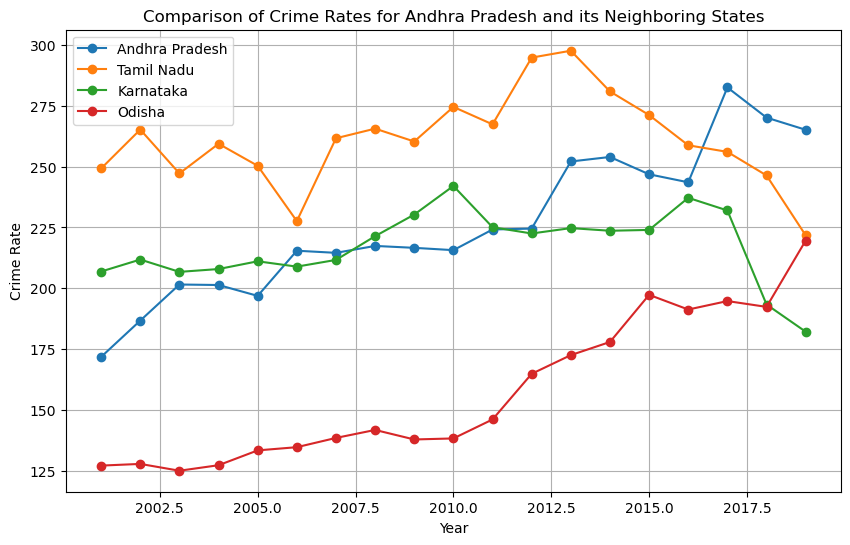

In [34]:
def plot_comparison_with_neighbors(state):
    neighbors = {
        'Andhra Pradesh': ['Tamil Nadu', 'Karnataka', 'Odisha'],
        'Arunachal Pradesh': ['Assam', 'Nagaland', 'Manipur', 'Mizoram'],
        'Assam': ['Arunachal Pradesh', 'Nagaland', 'Manipur', 'Mizoram', 'Meghalaya', 'Tripura'],
        'Bihar': ['Uttar Pradesh', 'Jharkhand', 'West Bengal'],
        'Chhattisgarh': ['Odisha', 'Jharkhand', 'Madhya Pradesh', 'Maharashtra'],
        'Goa': ['Maharashtra', 'Karnataka'],
        'Gujarat': ['Rajasthan', 'Maharashtra', 'Madhya Pradesh'],
        'Haryana': ['Punjab', 'Himachal Pradesh', 'Uttarakhand', 'Uttar Pradesh', 'Rajasthan'],
        'Himachal Pradesh': ['Jammu & Kashmir', 'Punjab', 'Haryana', 'Uttarakhand'],
        'Jharkhand': ['Bihar', 'Uttar Pradesh', 'Chhattisgarh', 'West Bengal', 'Odisha'],
        'Karnataka': ['Maharashtra', 'Goa', 'Kerala', 'Tamil Nadu', 'Andhra Pradesh'],
        'Kerala': ['Karnataka', 'Tamil Nadu'],
        'Madhya Pradesh': ['Rajasthan', 'Gujarat', 'Maharashtra', 'Chhattisgarh', 'Uttar Pradesh'],
        'Maharashtra': ['Gujarat', 'Madhya Pradesh', 'Chhattisgarh',  'Karnataka', 'Goa'],
        'Manipur': ['Nagaland', 'Mizoram', 'Assam'],
        'Meghalaya': ['Assam'],
        'Mizoram': ['Assam', 'Manipur', 'Tripura'],
        'Nagaland': ['Assam', 'Manipur', 'Arunachal Pradesh'],
        'Odisha': ['Chhattisgarh', 'Jharkhand', 'Andhra Pradesh', 'West Bengal'],
        'Punjab': ['Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Rajasthan'],
        'Rajasthan': ['Punjab', 'Haryana', 'Uttar Pradesh', 'Madhya Pradesh', 'Gujarat', 'Haryana'],
        'Sikkim': ['West Bengal', 'Bhutan', 'Nepal'],
        'Tamil Nadu': ['Kerala', 'Karnataka', 'Andhra Pradesh'],
        'Tripura': ['Assam', 'Mizoram'],
        'Uttar Pradesh': ['Bihar', 'Jharkhand', 'Madhya Pradesh', 'Rajasthan', 'Haryana', 'Uttarakhand'],
        'Uttarakhand': ['Uttar Pradesh', 'Haryana', 'Himachal Pradesh'],
        'West Bengal': ['Bihar', 'Jharkhand', 'Odisha', 'Sikkim', 'Assam'],
        'Andaman and Nicobar Islands': [],
        'Chandigarh': ['Punjab', 'Haryana'],
        'Dadra and Nagar Haveli and Daman and Diu': ['Gujarat', 'Maharashtra'],
        'Lakshadweep': [],
        'Delhi': ['Haryana', 'Uttar Pradesh', 'Rajasthan', 'Haryana', 'Uttar Pradesh'],
        'Puducherry': ['Tamil Nadu'],
    }
    data_neighbors = pd.read_csv("State+UT Wise Crime Data of India (IPC) 2001-2019 .csv")
    states_to_plot = [state] + neighbors.get(state, [])
    # print(states_to_plot)
    state_data = data_neighbors[data_neighbors['State_UT'].isin(states_to_plot)]
    # print(state_data)
    plt.figure(figsize=(10, 6))
    for st in states_to_plot:
        state_subset = state_data[state_data['State_UT'] == st]
        plt.plot(state_subset['Year'].astype(int), state_subset['Crime_Rate'], marker='o', label=st)
    plt.title('Comparison of Crime Rates for {} and its Neighboring States'.format(state))
    plt.xlabel('Year')
    plt.ylabel('Crime Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

user_input_state = 'Andhra Pradesh'
plot_comparison_with_neighbors(user_input_state)

Predicted Crime Rate: [171.42912656]


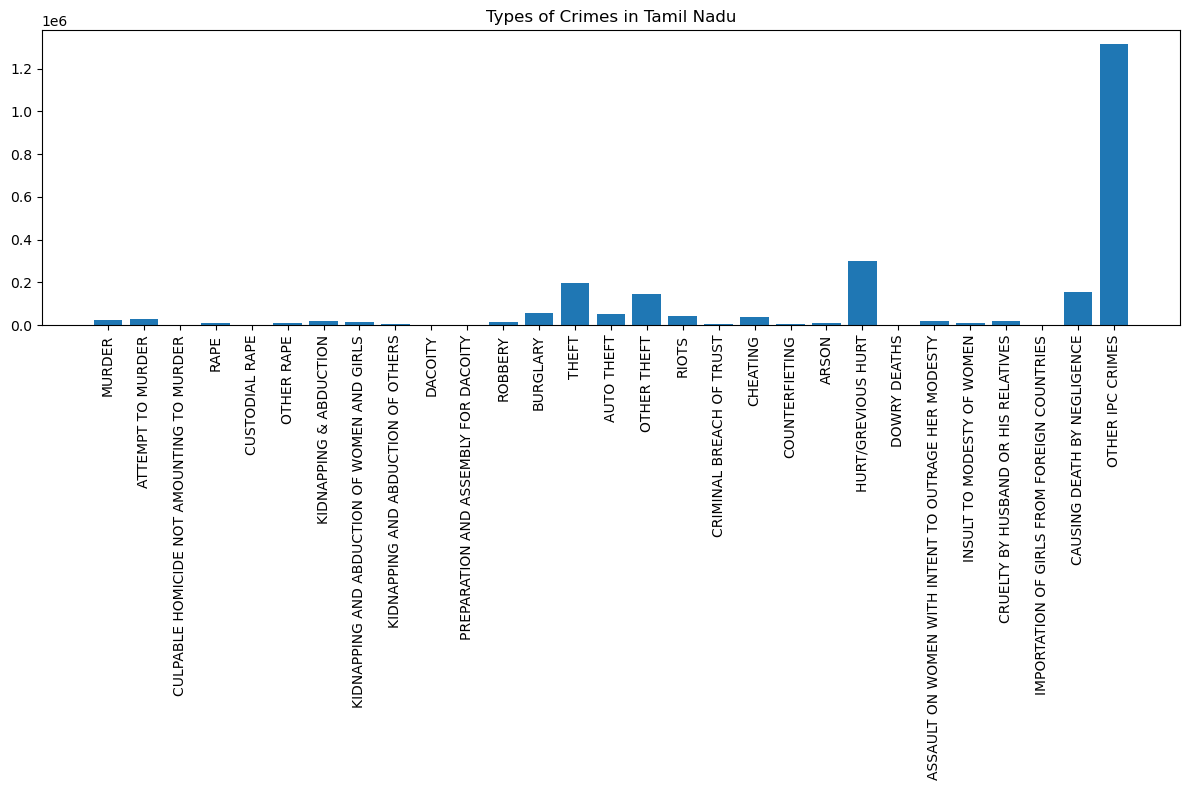

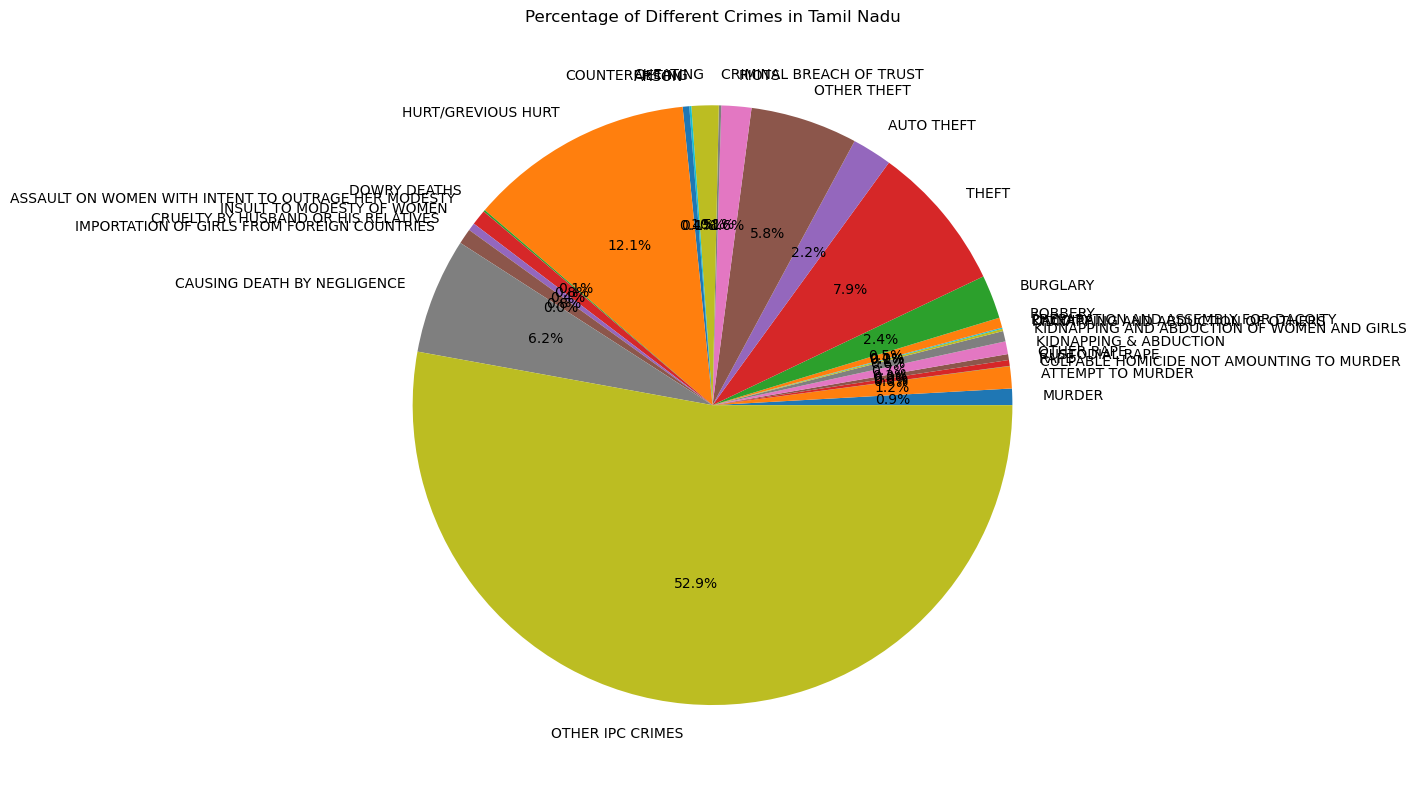

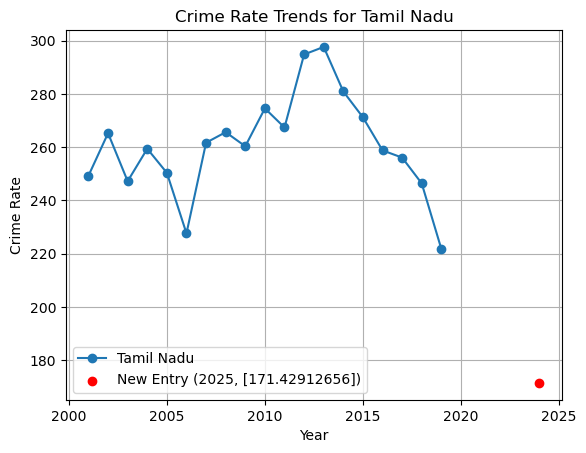

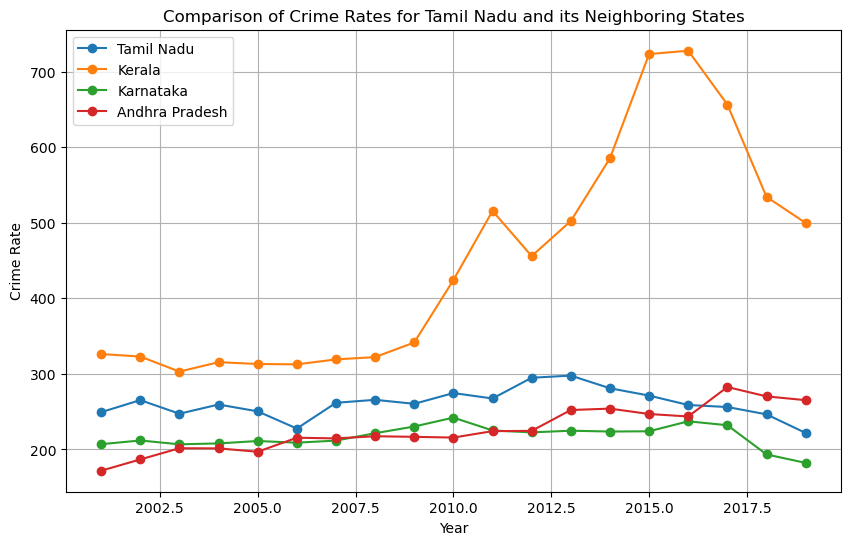

In [42]:
def predict_crime_rate():
    user_input_year = int(input("Enter the year: "))
    user_input_category = input("Enter the category: ")
    user_input_state = input("Enter the state/UT: ")

    user_input = pd.DataFrame({'Year': [user_input_year], 'Category': [user_input_category], 'State_UT': [user_input_state]})
    user_input_encoded = transformer.transform(user_input)
    user_input_scaled = scaler.transform(user_input_encoded)
    user_input_reshaped = user_input_scaled.toarray().reshape((user_input_scaled.shape[0], user_input_scaled.shape[1]))

    predicted_crime_rate = stregr.predict(user_input_reshaped)
    print("Predicted Crime Rate:", predicted_crime_rate)
    plot_crimes_for_state(user_input_state, plot_type='bar')
    plot_crimes_for_state(user_input_state, plot_type='pie')
    plot_trends_with_new_entry(user_input_state, int(user_input_year), predicted_crime_rate)
    plot_comparison_with_neighbors(user_input_state)
    
predict_crime_rate()